### Rabi Oscillations

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import about, basis, destroy, mesolve, qeye, sigmaz, tensor

In [21]:
N = 15  # number of cavity fock states
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
n_th_a = 0.0  # temperature in frequency units
use_rwa = True

tlist = np.linspace(0, 100, 1000)

In [22]:
# intial state
psi0 = tensor(basis(N, 0), basis(2, 0))

# collapse operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())
sz = tensor(qeye(N), sigmaz())

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + wa / 2 * sz + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * a.dag() * a + wa / 2 * sz + g * (a.dag() + a) * (sm + sm.dag())

In [23]:
c_op_list = []

# Photon annihilation
rate = kappa * (1 + n_th_a)
c_op_list.append(np.sqrt(rate) * a)

# Photon creation
rate = kappa * n_th_a
c_op_list.append(np.sqrt(rate) * a.dag())

# Atom annihilation
rate = gamma
c_op_list.append(np.sqrt(rate) * sm)

In [24]:
output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a, sm.dag() * sm])

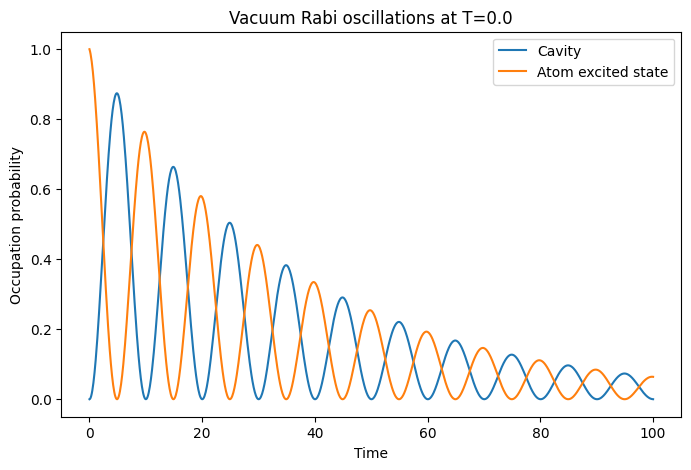

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, output.expect[0], label="Cavity")
ax.plot(tlist, output.expect[1], label="Atom excited state")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Vacuum Rabi oscillations at T={}".format(n_th_a));

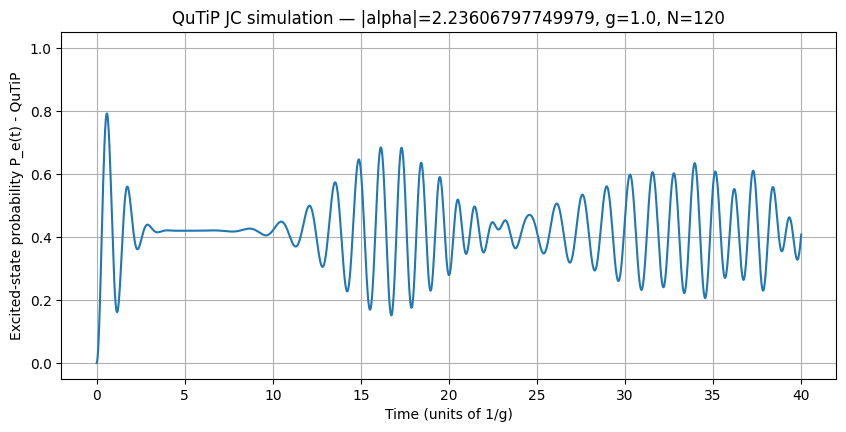

In [33]:
# QuTiP simulation of collapse & revival (unitary evolution)
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, coherent, tensor, sigmaz, destroy, qeye, mesolve, expect
import pandas as pd

# Parameters (match these to the analytic run)
g = 1.0
alpha = np.sqrt(5)
N = 120             # Hilbert space truncation for the field
wc = 1.0            # cavity freq (set to 1 for resonance units)
wa = 1.0            # atom freq (resonant)
t_max = 40
nt = 2000
tlist = np.linspace(0, t_max, nt)

# Field operator (N x N)
a = destroy(N)

# Atomic operators (2 x 2) — do NOT tensor them with qeye here
sm_atom = destroy(2)        # sigma_- on the two-level atom
sp_atom = sm_atom.dag()
sz_atom = sigmaz()          # 2x2 Pauli z

# Now build full-system operators by tensoring atom ⊗ field
a_full = tensor(qeye(2), a)            # identity on atom, a on field
adag_a_full = tensor(qeye(2), a.dag()*a)
sz_full = tensor(sz_atom, qeye(N))
sm_full = tensor(sm_atom, qeye(N))
sp_full = tensor(sp_atom, qeye(N))

# Hamiltonian H = wc a^\dag a + wa/2 sigma_z + g (a^\dagger sigma_- + a sigma_+)
H = wc * tensor(qeye(2), a.dag()*a) + 0.5*wa * tensor(sigmaz(), qeye(N)) \
    + g * (tensor(sp_atom, a) + tensor(sm_atom, a.dag()))

# Initial state: |e> ⊗ |alpha>
psi0 = tensor(basis(2,1), coherent(N, alpha))

# Unitarty evolution (closed system) using mesolve with no collapse operators
result = mesolve(H, psi0, tlist, c_ops=[], e_ops=[sz])

# Expectation of sigma_z -> convert to P_e
sz_t = result.expect[0]          # <sigma_z>(t)
P_e_qutip = 0.5 * (1 + sz_t)

# (Optional) quick plot
plt.figure(figsize=(10,4.5))
plt.plot(tlist, P_e_qutip)
plt.xlabel('Time (units of 1/g)')
plt.ylabel('Excited-state probability P_e(t) - QuTiP')
plt.title(f'QuTiP JC simulation — |alpha|={alpha}, g={g}, N={N}')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()
